In [1]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\georg\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [2]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import tokenize
import pandas as pd

data = pd.read_csv("all_ECB_speeches.csv", sep="|", encoding="utf-8")
print("Shape DataFrame: ", data.shape)
print("Data size: ", data.shape[0])
data_drop_nan = data.dropna(subset=data.columns)
data.dropna(subset=data.columns, inplace=True)
print("Dropando NaN")
print("Data size: ", data_drop_nan.shape[0] )
data.head()

Shape DataFrame:  (2772, 5)
Data size:  2772
Dropando NaN
Data size:  2683


,date,speakers,title,subtitle,contents
0,2024-02-26,Christine Lagarde,European Parliament plenary debate on the ECB ...,"Speech by Christine Lagarde, President of the ...",SPEECH European Parliament plenary debate ...
2,2024-02-16,Isabel Schnabel,From laggard to leader? Closing the euro area’...,Inaugural lecture of the EMU Lab by Isabel Sch...,SPEECH From laggard to leader? Closing the ...
4,2024-02-15,Christine Lagarde,Hearing of the Committee on Economic and Monet...,"Speech by Christine Lagarde, President of the ...",SPEECH Hearing of the Committee on Economic...
6,2024-02-14,Piero Cipollone,Preserving people’s freedom to use a public me...,"Introductory statement by Piero Cipollone, Mem...",SPEECH Preserving people’s freedom to ...
7,2024-02-14,Luis de Guindos,"Monetary policy, financial stability and mediu...","Speech by Luis de Guindos, Vice-President of t...","SPEECH Monetary policy, financial stability..."


In [15]:
example = data.loc[0, 'contents'].split("2024 ")[1]
example_list = tokenize.sent_tokenize(example)
example_list

['As we approach the end of this legislative term, I wish to sincerely thank this Parliament for collaborating in guiding Europe through economic headwinds and geopolitical upheavals, always with the shared vision of bolstering prosperity and fortifying our resilience.',
 'Building on this collaborative spirit, today’s debate on your draft resolution on the ECB Annual Report is a pillar of the ongoing dialogue between our two institutions; indeed, it is fundamental to the ECB’s accountability which ensures the democratic legitimacy of our actions.',
 'Let me start by outlining the current state of the euro area economy and our monetary policy stance.',
 'I will then focus on the need for a common European response to strengthen euro area resilience and competitiveness.',
 'Bringing inflation back to target in a challenging economic and geopolitical environment The euro area has been facing significant headwinds from a series of sudden and consecutive shocks which pushed inflation very 

- pos: o quão positiva é aquele frase/documento;
- neu: o quão neutra é a frase/documento;
- neg: o quanto é negativa;
- compound: uma pontuação composta que é calculada somando as pontuações de valência de cada palavra no léxico, o que gera um número entre -1 (muito negativo) e +1 (muito positivo).

In [16]:
for sentence in example_list:
    sid = SentimentIntensityAnalyzer()
    print(sentence)
    ss = sid.polarity_scores(sentence)
    for k in sorted(ss):
        print('{0}: {1}, '.format(k, ss[k]), end='')
    print()

As we approach the end of this legislative term, I wish to sincerely thank this Parliament for collaborating in guiding Europe through economic headwinds and geopolitical upheavals, always with the shared vision of bolstering prosperity and fortifying our resilience.
compound: 0.8934, neg: 0.0, neu: 0.722, pos: 0.278, 
Building on this collaborative spirit, today’s debate on your draft resolution on the ECB Annual Report is a pillar of the ongoing dialogue between our two institutions; indeed, it is fundamental to the ECB’s accountability which ensures the democratic legitimacy of our actions.
compound: 0.1779, neg: 0.0, neu: 0.96, pos: 0.04, 
Let me start by outlining the current state of the euro area economy and our monetary policy stance.
compound: 0.0, neg: 0.0, neu: 1.0, pos: 0.0, 
I will then focus on the need for a common European response to strengthen euro area resilience and competitiveness.
compound: 0.3182, neg: 0.0, neu: 0.874, pos: 0.126, 
Bringing inflation back to targ

# Série Temporal por Discursante

In [14]:
import re
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

In [11]:
def speaker_time_series(speaker):
    df = data.loc[data["speakers"] == speaker].dropna().reset_index(drop=True)
    discourses_results = []
    for row in range(df.shape[0]):
        results = {"compound": [], "neg": [], "neu": [], "pos": []}

        try:
            speech = re.split(
                " \d+ (January|February|March|April|May|June|July|August|September|October|November|December) \d{4} ",
                df.loc[row, "contents"]
            )[2]
        except:
            speech = df.loc[row, "contents"]
        
        sentence_list = tokenize.sent_tokenize(speech)
        for sentence in sentence_list:
            sid = SentimentIntensityAnalyzer()
            scores = sid.polarity_scores(sentence)
            for k in sorted(scores):
                results[k].append(scores[k])
        
        discourses_results.append(pd.DataFrame(results))
    
    return df["date"].apply(lambda x: datetime.strptime(x, "%Y-%m-%d")).values, discourses_results

In [12]:
dates, discourses_results = speaker_time_series("Luis de Guindos")
means_df = pd.concat([x.mean() for x in discourses_results], axis=1).T
means_df.index = dates
data["speakers"].unique()

array(['Christine Lagarde', 'Isabel Schnabel', 'Piero Cipollone',
       'Luis de Guindos', 'Philip R. Lane', 'Frank Elderson',
       'Fabio Panetta', 'Yves Mersch', 'Benoît Cœuré',
       'Sabine Lautenschläger', 'Mario Draghi', 'Peter Praet',
       'Vítor Constâncio', 'Jörg Asmussen', 'José Manuel González-Páramo',
       'Lorenzo Bini Smaghi', 'Jürgen Stark', 'Jean-Claude Trichet',
       'Gertrude Tumpel-Gugerell', 'Lucas Papademos', 'Otmar Issing',
       'Tommaso Padoa-Schioppa', 'Eugenio Domingo Solans',
       'Willem F. Duisenberg', 'Sirkka Hämäläinen', 'Christian Noyer',
       'Willem F. Duisenberg,Eugenio Domingo Solans',
       'Alexandre Lamfalussy'], dtype=object)

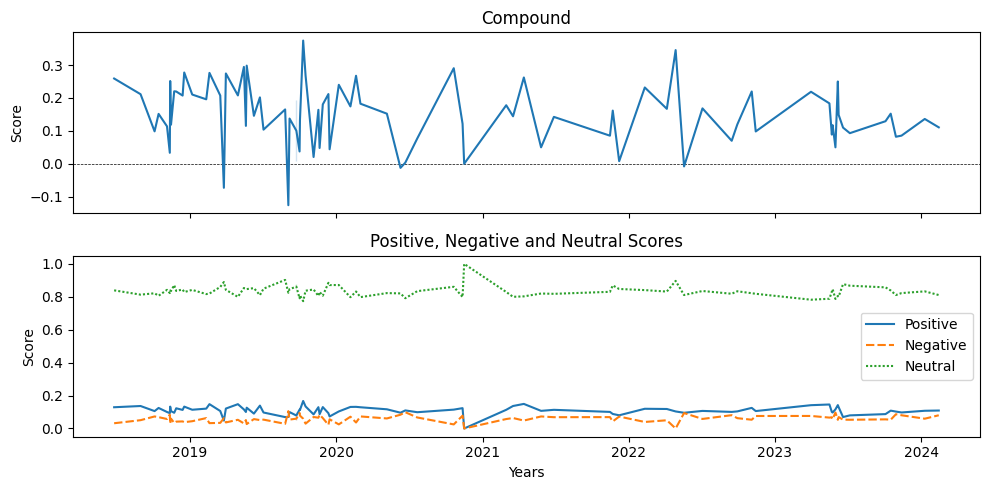

In [13]:
means_df.rename(columns={"compound": "Compound", "neg": "Negative", "neu": "Neutral", "pos": "Positive"}, inplace=True)

fig, axis = plt.subplots(2,1 , figsize=(10, 5), sharex=True)

axis[0].axhline(0, color="black", linestyle="--", linewidth=0.5)
axis[0].set_title("Compound")
axis[0].set_ylabel("Score")

axis[1].set_title("Positive, Negative and Neutral Scores")
axis[1].set_ylabel("Score")
axis[1].set_xlabel("Years")


sns.lineplot(data=means_df["Compound"], ax=axis[0])
sns.lineplot(data=means_df[["Positive", "Negative", "Neutral"]], ax=axis[1])

plt.tight_layout()

C:\Users\georg\AppData\Local\Temp\ipykernel_3676\1220250874.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axis = plt.subplots(2,1 , figsize=(10, 5), sharex=True)


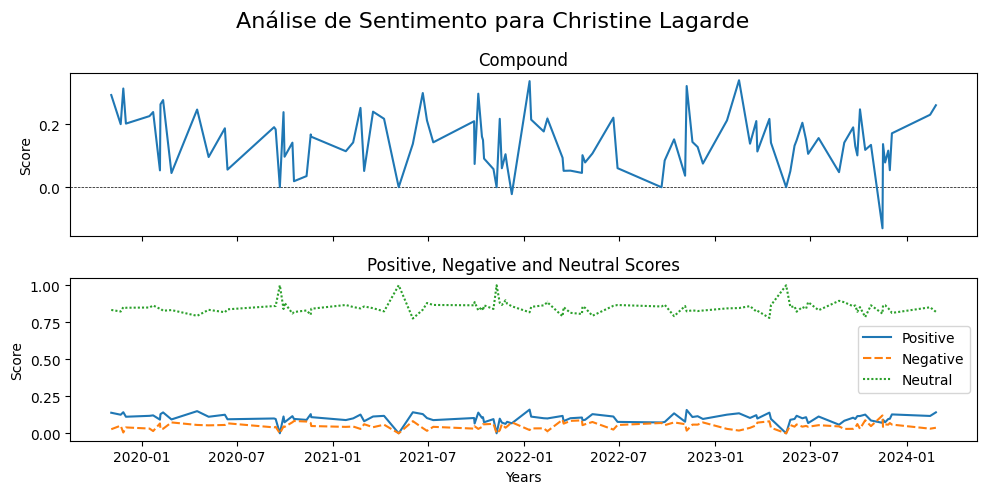

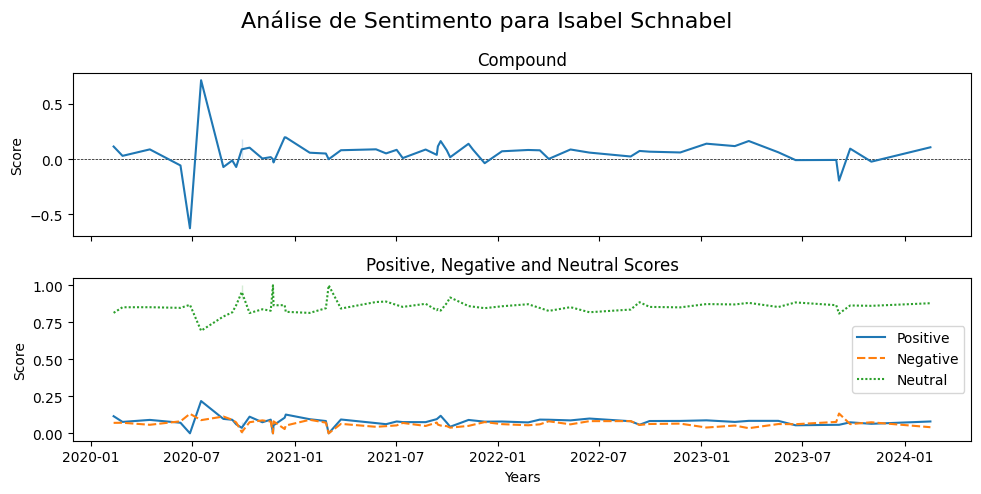

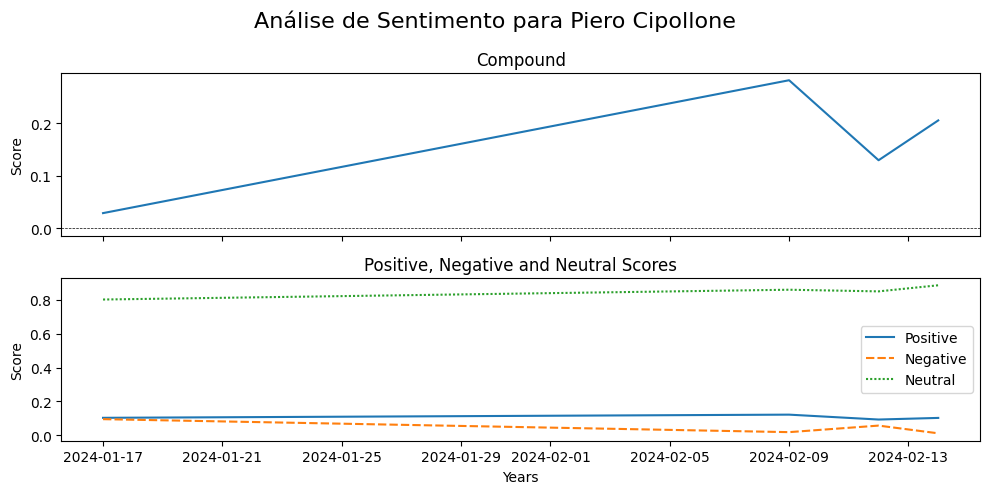

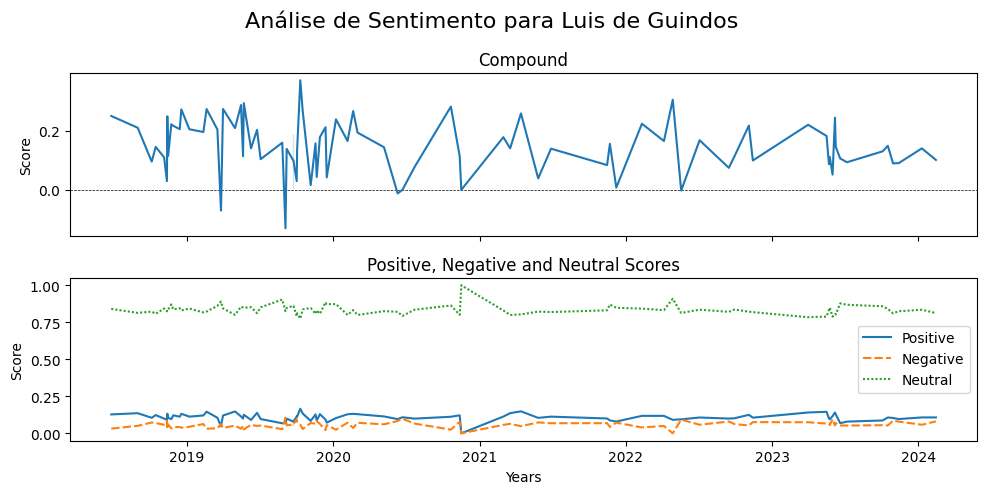

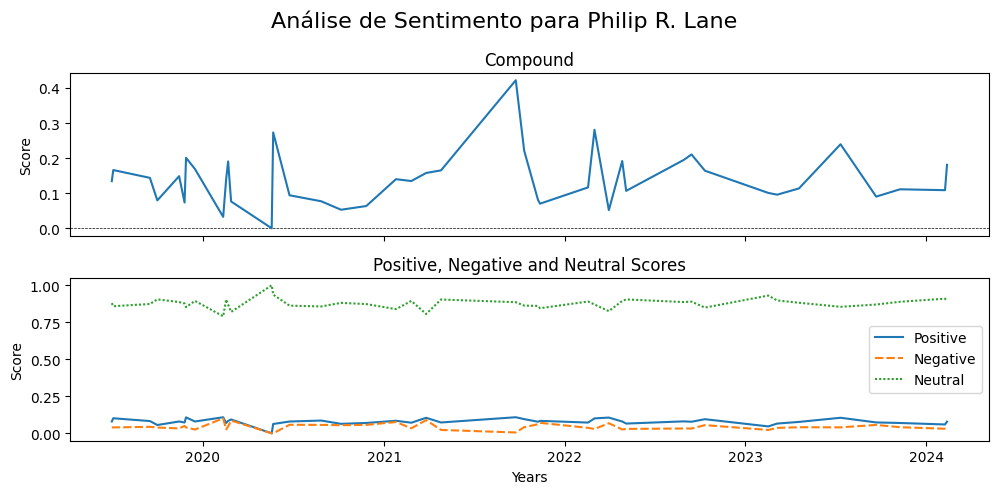

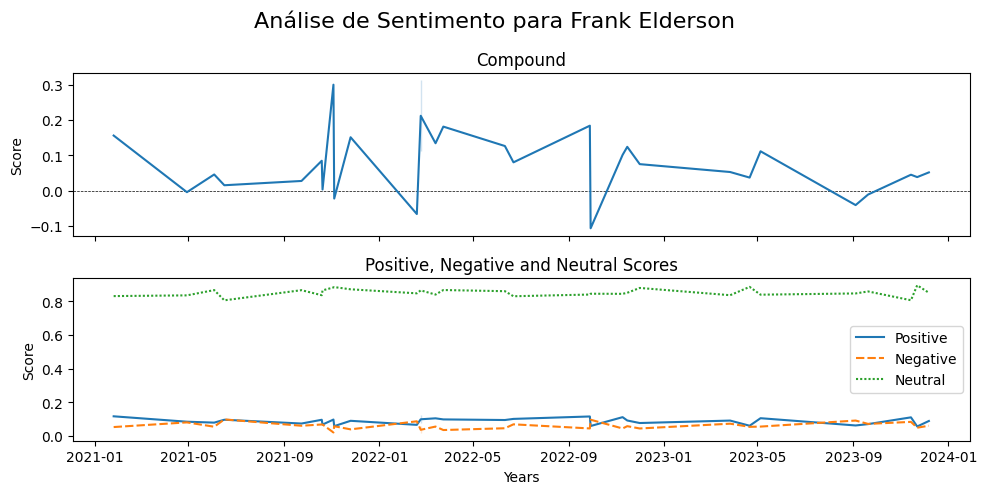

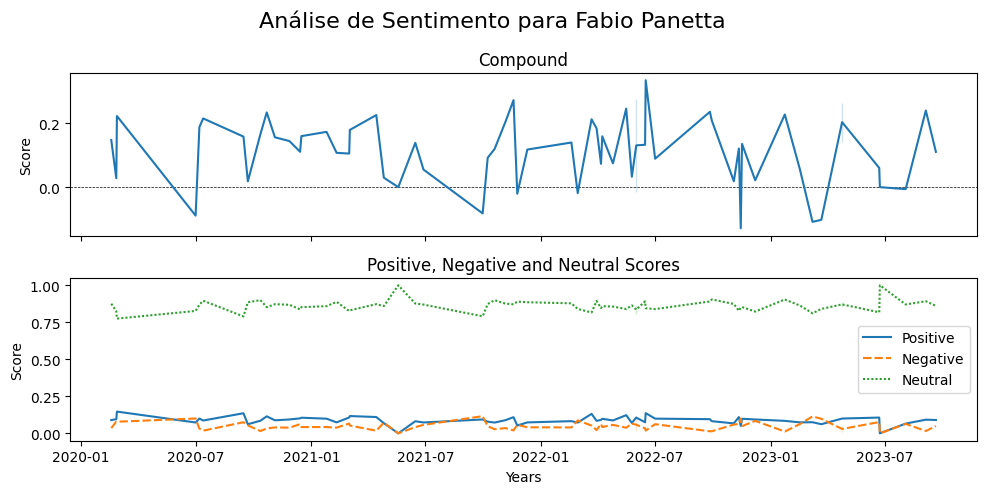

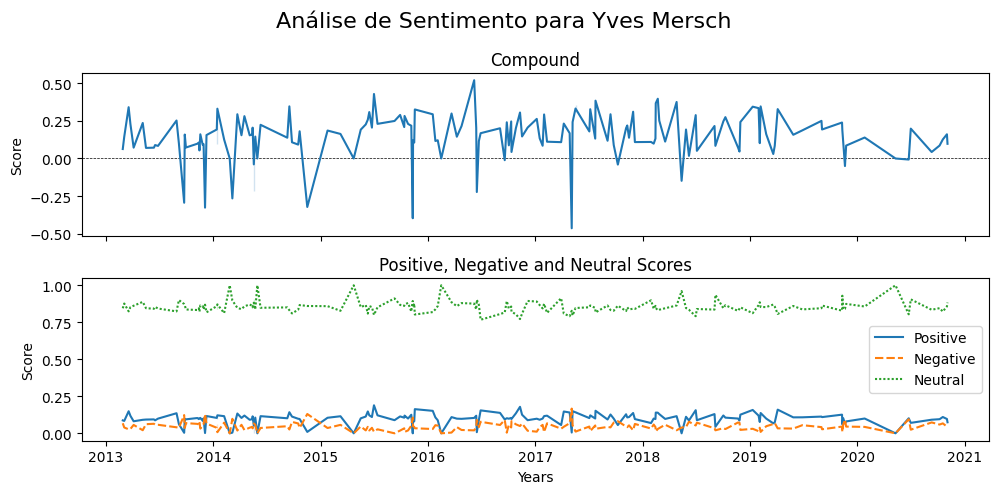

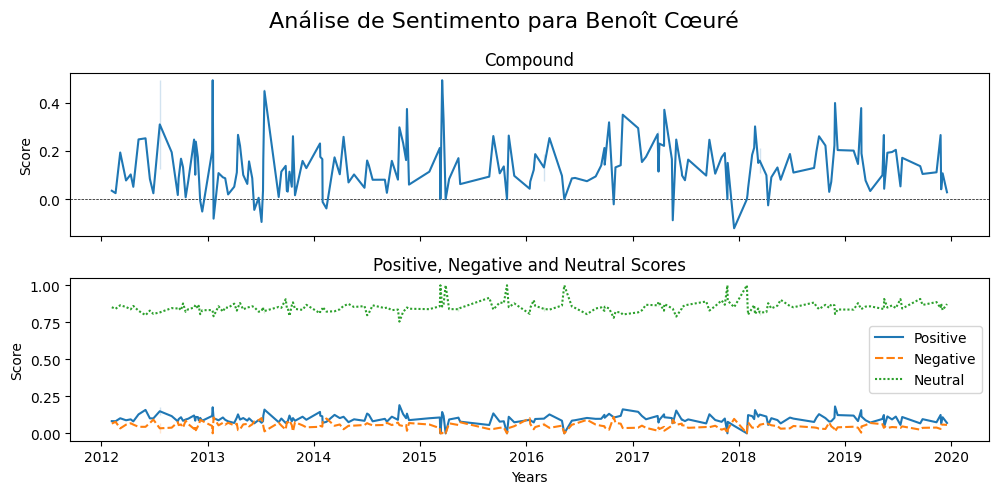

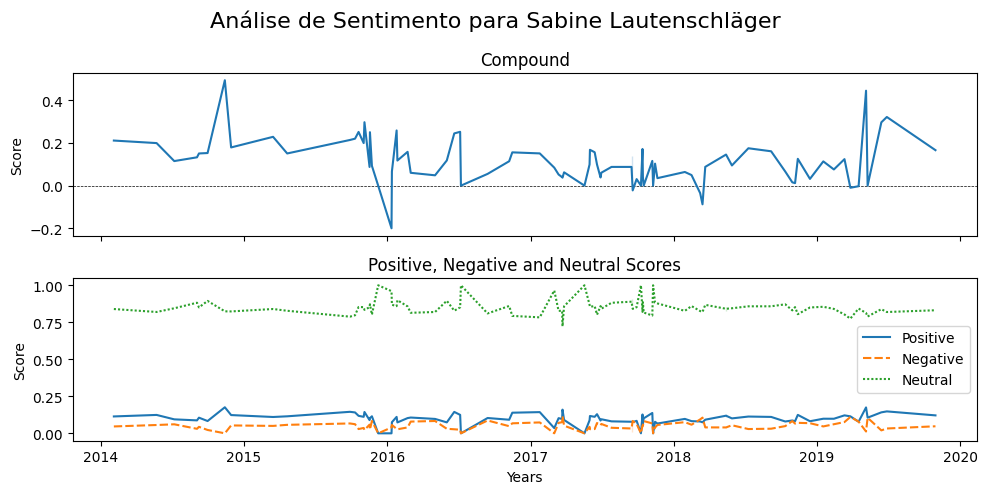

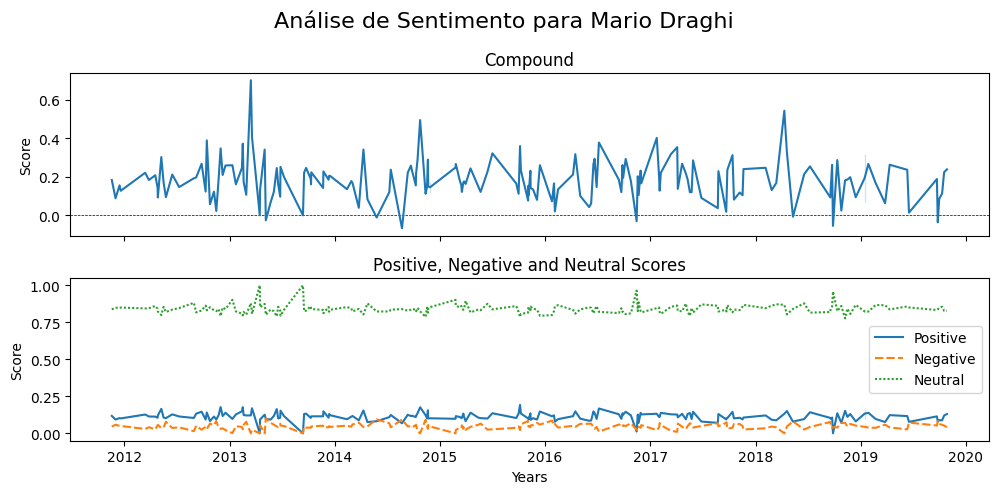

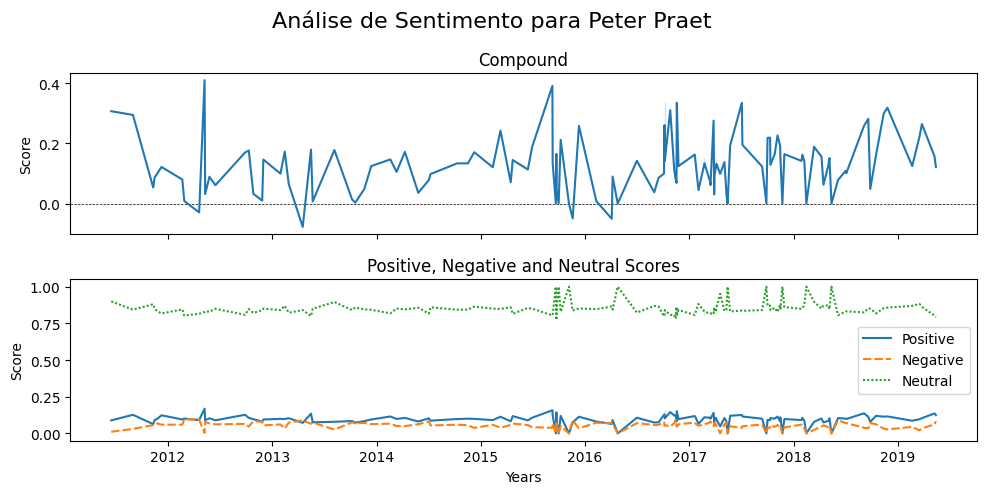

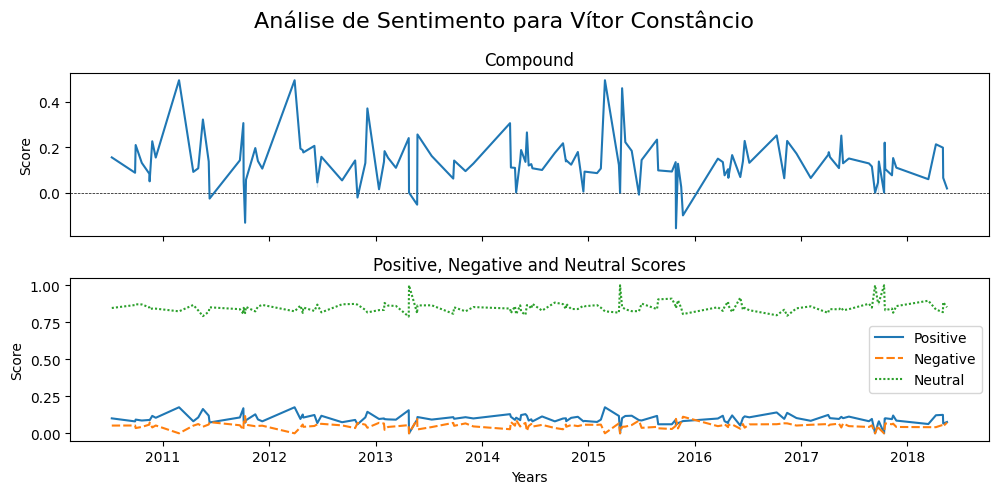

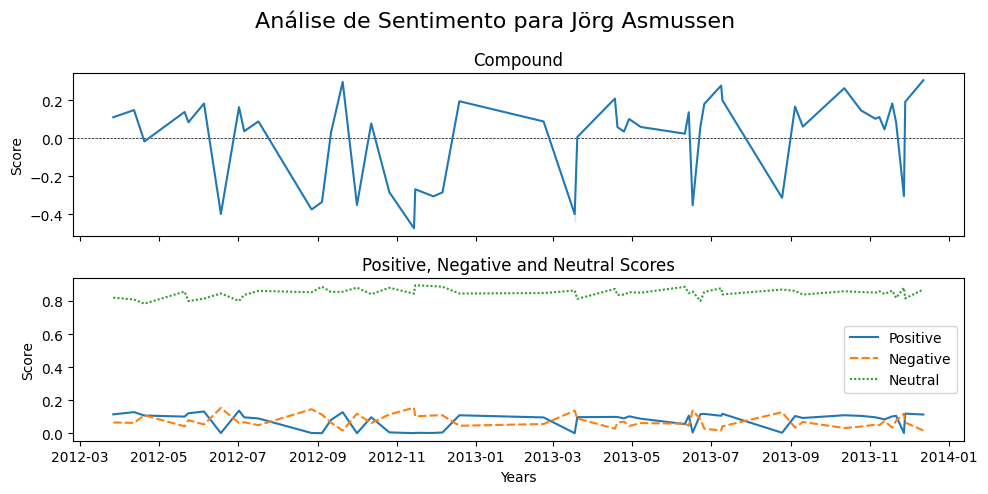

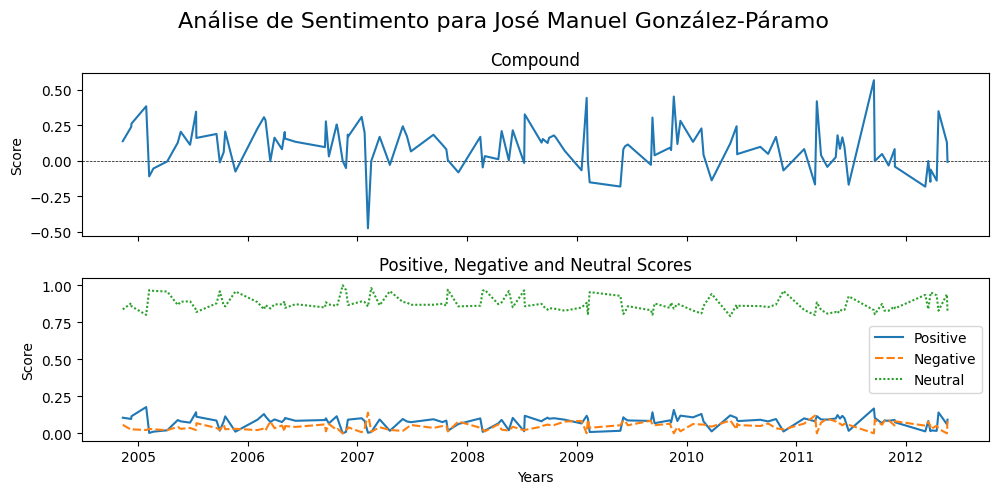

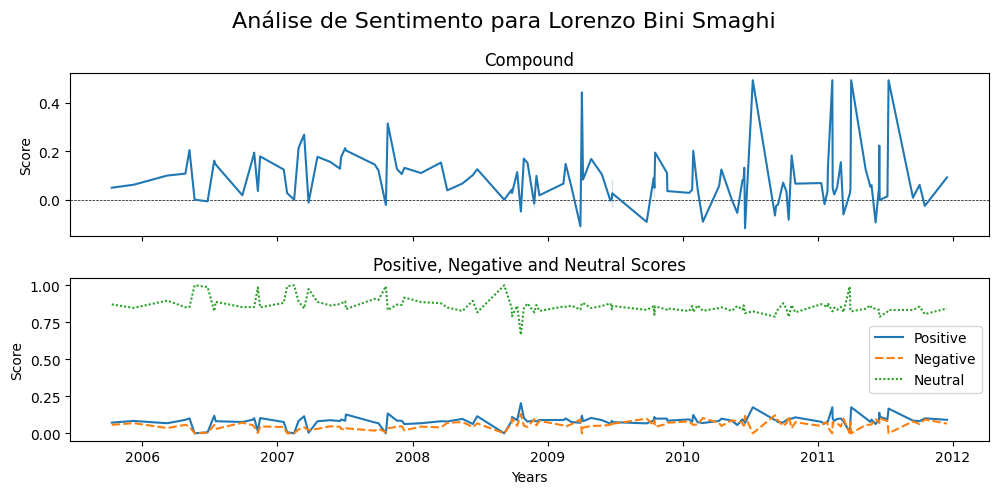

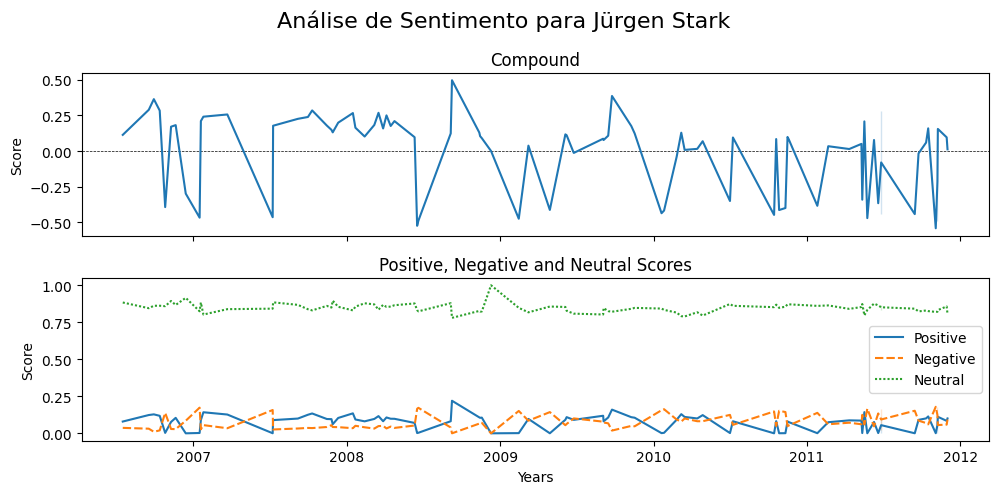

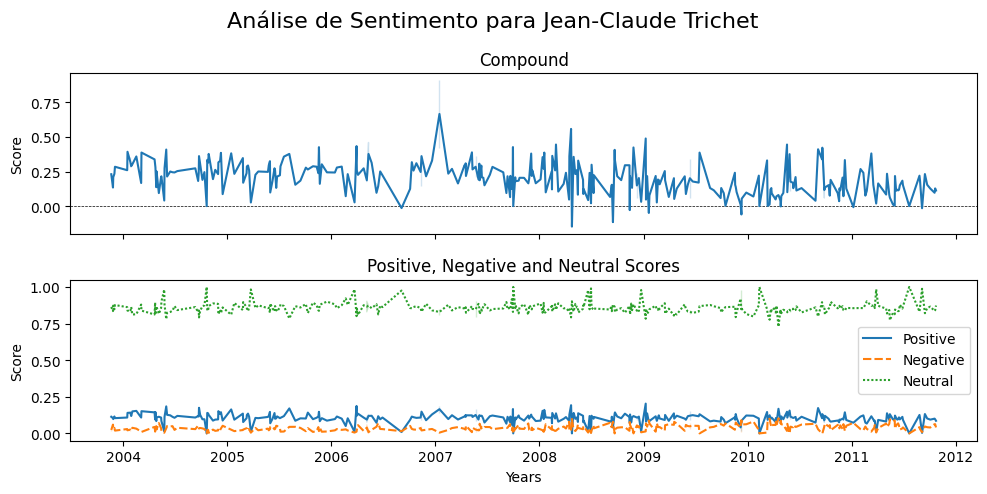

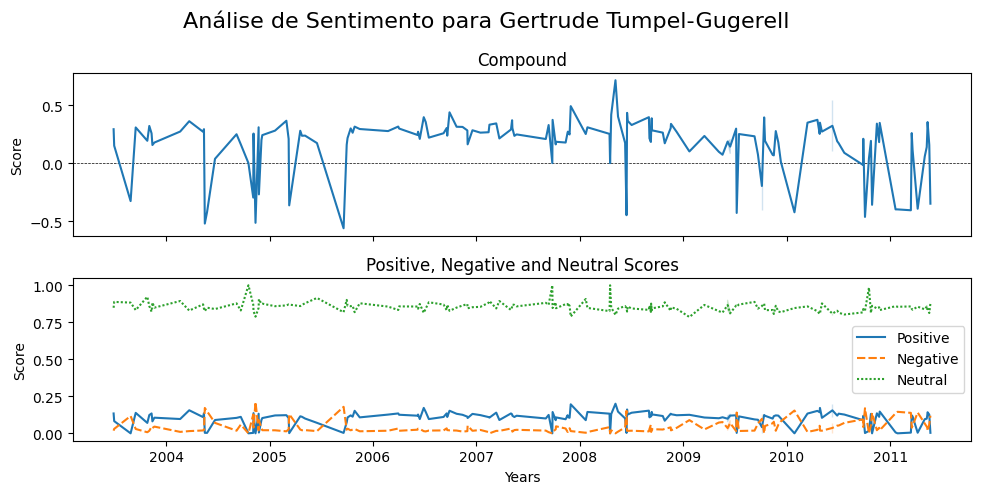

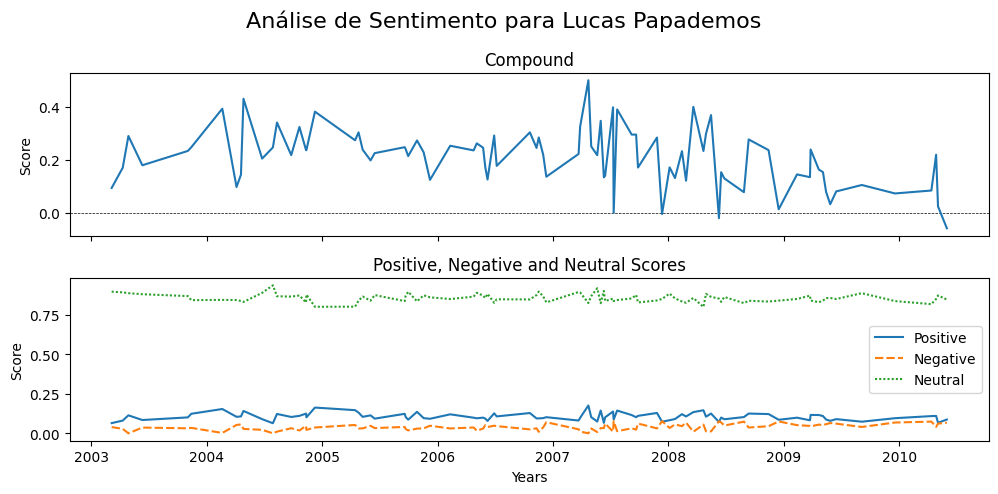

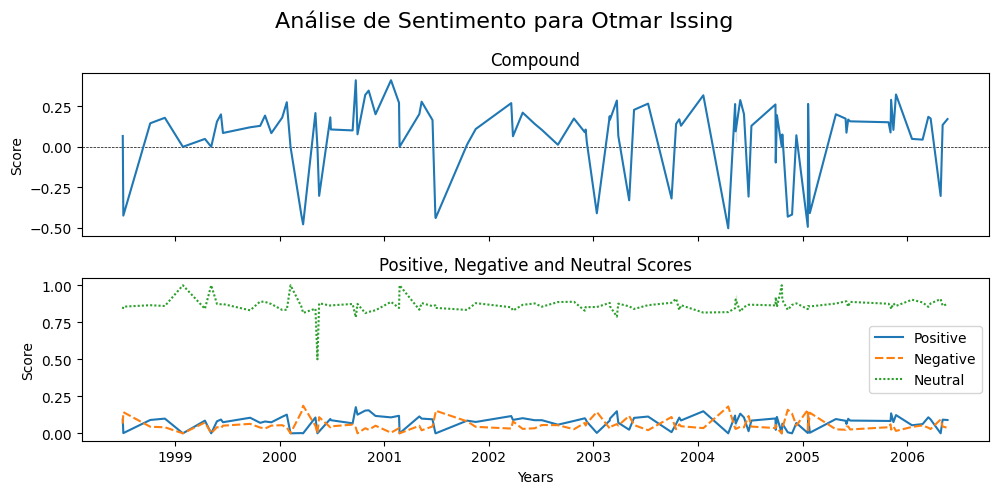

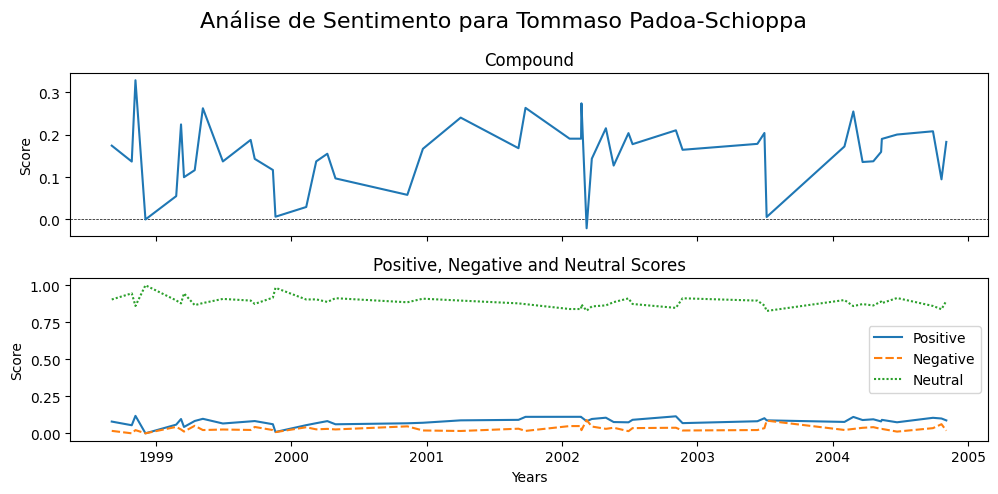

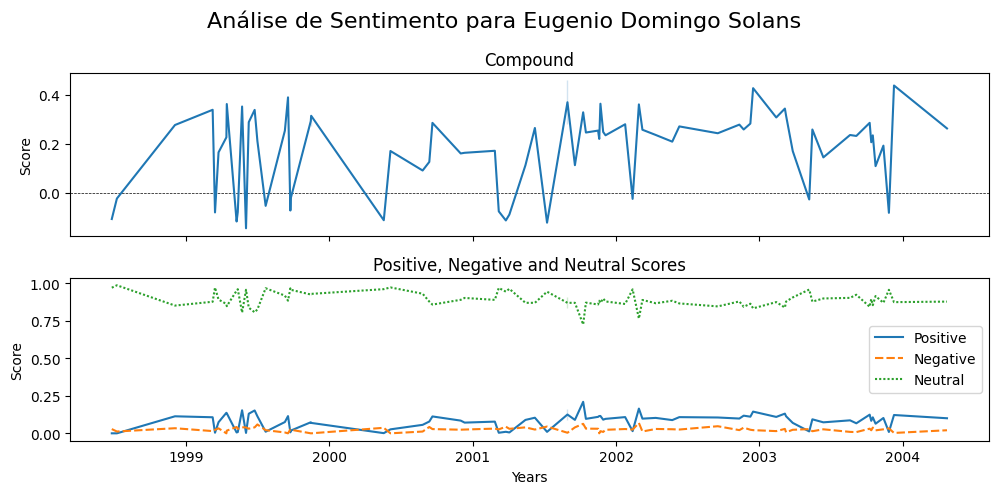

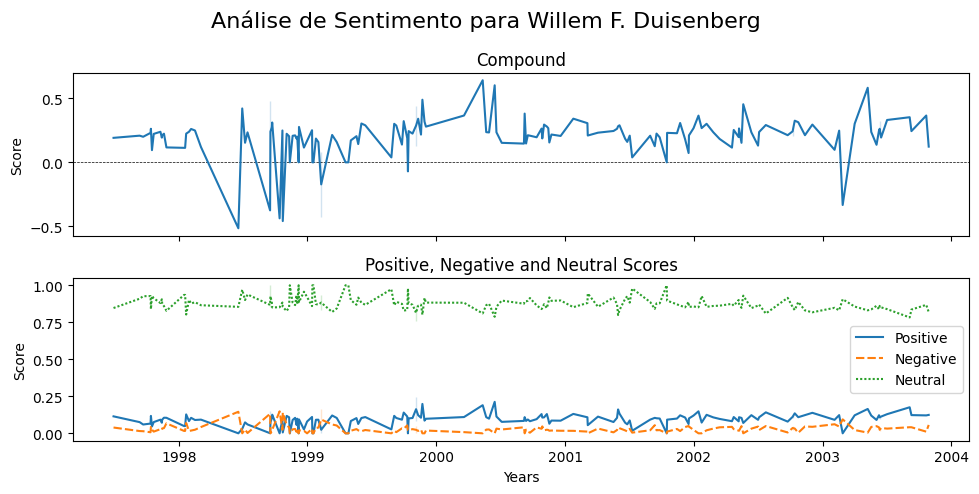

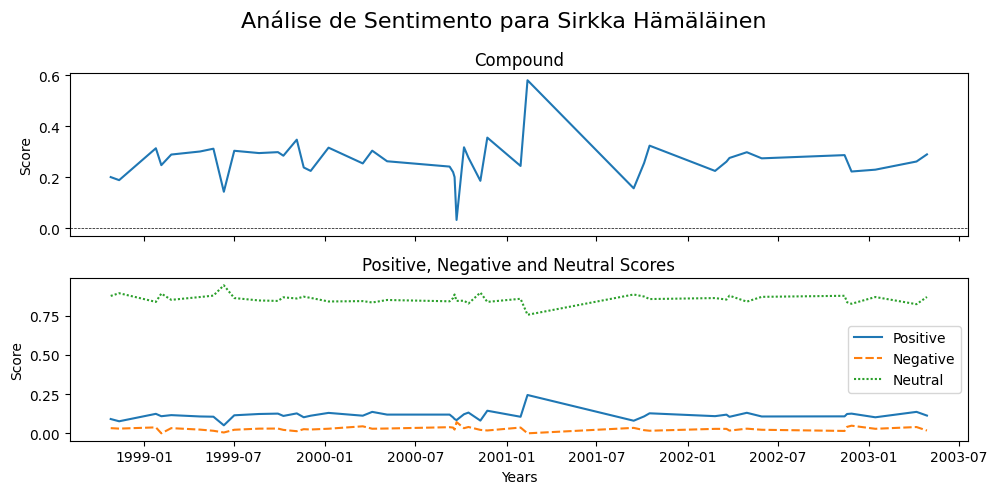

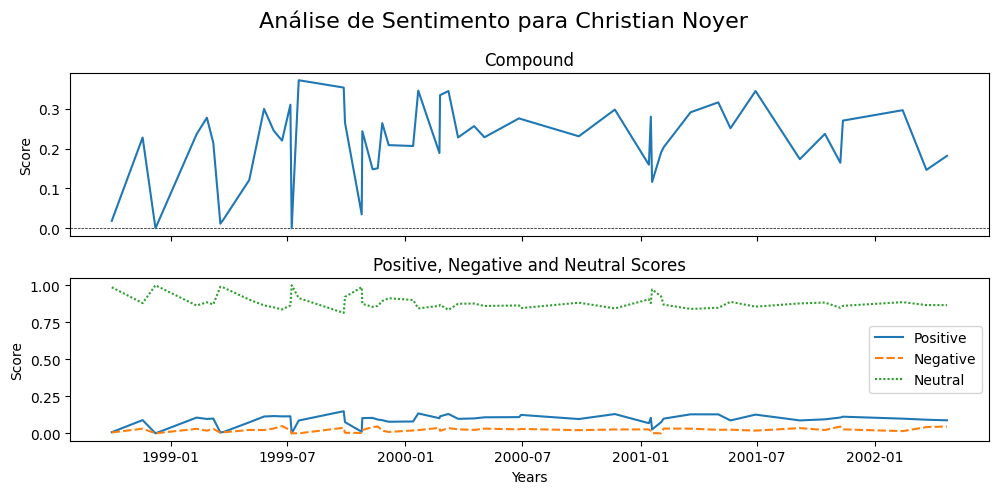

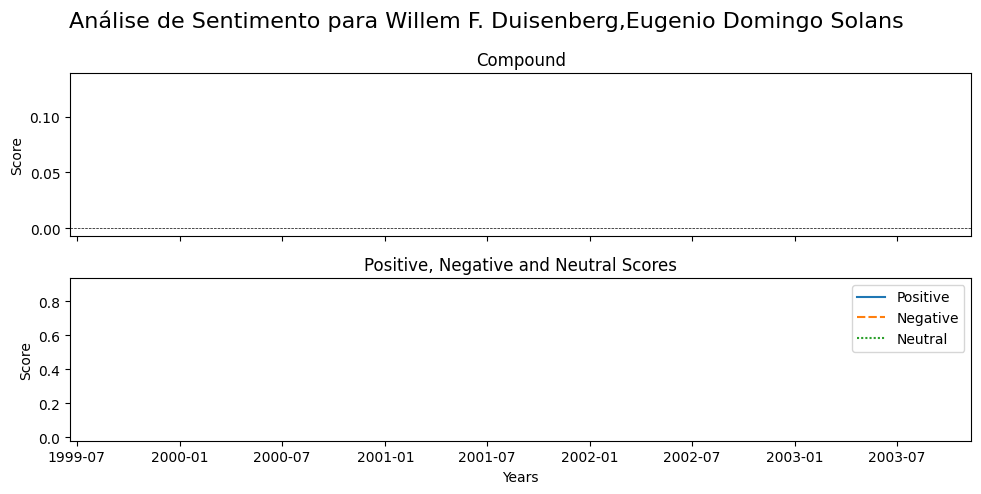

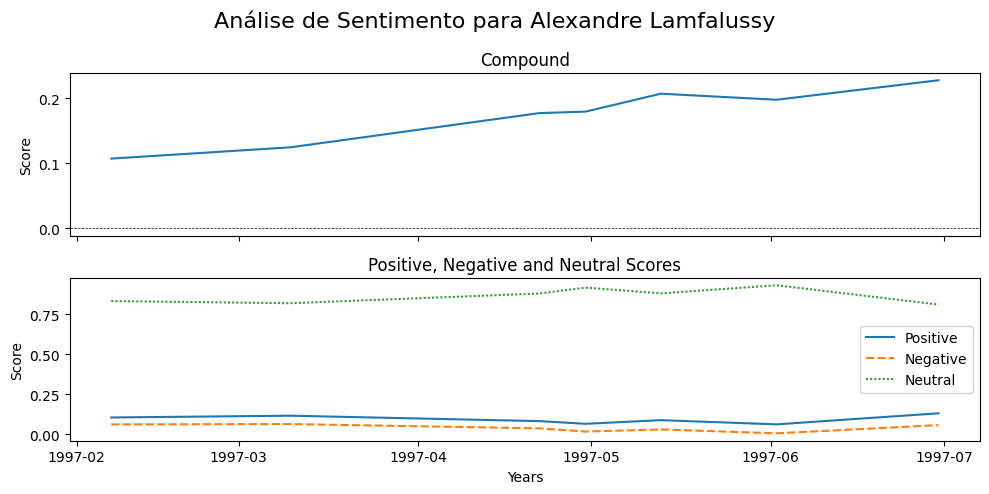

In [82]:
for speaker in data["speakers"].unique():
    dates, discourses_results = speaker_time_series(speaker)
    means_df = pd.concat([x.mean() for x in discourses_results], axis=1).T
    means_df.index = dates

    means_df.rename(columns={"compound": "Compound", "neg": "Negative", "neu": "Neutral", "pos": "Positive"}, inplace=True)

    fig, axis = plt.subplots(2,1 , figsize=(10, 5), sharex=True)
    fig.suptitle(f"Análise de Sentimento para {speaker}", fontsize=16)

    axis[0].axhline(0, color="black", linestyle="--", linewidth=0.5)
    axis[0].set_title("Compound")
    axis[0].set_ylabel("Score")

    axis[1].set_title("Positive, Negative and Neutral Scores")
    axis[1].set_ylabel("Score")
    axis[1].set_xlabel("Years")

    sns.lineplot(data=means_df["Compound"], ax=axis[0])
    sns.lineplot(data=means_df[["Positive", "Negative", "Neutral"]], ax=axis[1])

    plt.tight_layout()